# 03 · Auditoria de Features
## Detecção e Prevenção de Data Leakage

<div align="center">

```
┌─────────────────────────────────────────────────────────────┐
│     FEATURE AUDIT PIPELINE - LEAKAGE DETECTION v2.0        │
└─────────────────────────────────────────────────────────────┘
```

![Status](https://img.shields.io/badge/Status-Audit%20Complete-success)
![Priority](https://img.shields.io/badge/Priority-CRITICAL-red)
![Version](https://img.shields.io/badge/Version-2.0-blue)

</div>

---

### OBJETIVO

Identificar e eliminar data leakage que causa a severa lacuna entre performance de treino e teste, garantindo generalização adequada do modelo.

### PROBLEMA IDENTIFICADO

```
PERFORMANCE GAP ANALYSIS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Training PR-AUC     : 0.999  [████████████████████] Perfect
Test PR-AUC         : 0.007  [█                   ] Random
Gap                 : 153x degradation (CRITICAL)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
```

### CAUSAS POTENCIAIS

<table>
<tr><th>Causa</th><th>Impacto</th><th>Probabilidade</th></tr>
<tr><td>Features com informação futura</td><td>`CRITICAL`</td><td>Alta</td></tr>
<tr><td>Encoding fit no dataset completo</td><td>`HIGH`</td><td>Muito Alta</td></tr>
<tr><td>Agregações temporais incorretas</td><td>`HIGH`</td><td>Alta</td></tr>
<tr><td>SMOTE criando padrões artificiais</td><td>`MEDIUM`</td><td>Média</td></tr>
<tr><td>Target leakage em features derivadas</td><td>`CRITICAL`</td><td>Média</td></tr>
</table>

### ESTRATÉGIA DE AUDITORIA

```
┌────────────────┐    ┌────────────────┐    ┌────────────────┐
│   Inventário   │ -> │  Validação     │ -> │  Correlação    │
│   de Features  │    │   Temporal     │    │   & IV         │
└────────────────┘    └────────────────┘    └────────────────┘
         │                                            │
         └─────────────────┐       ┌────────────────┘
                           ▼       ▼
                   ┌────────────────────┐
                   │    Adversarial     │
                   │    Validation      │
                   └────────────────────┘
```

> **ATENÇÃO CRÍTICA:** Este notebook identifica sources de leakage que invalidam métricas de modelo. Resultados determinam necessidade de re-engenharia completa de features.

---

In [8]:
# Environment Setup
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add utils to path
sys.path.append(str(Path('..').resolve()))

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import json
from datetime import datetime

# ML imports
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

sys.path.append('../utils')
# Utils
from data import load_data, load_artifact

# Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Load config
with open('../config.yaml', 'r') as f:
    CONFIG = yaml.safe_load(f)

# Paths
notebook_dir = Path('.').resolve().parent
DATA_DIR = notebook_dir / CONFIG['paths']['data']
ARTIFACTS_DIR = notebook_dir / CONFIG['paths']['artifacts']

print("[OK] Environment configured")
print(f"Data directory: {DATA_DIR}")
print(f"Artifacts directory: {ARTIFACTS_DIR}")

[OK] Environment configured
Data directory: C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\data
Artifacts directory: C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts


## ▸ SEÇÃO 1: Carregamento de Dados e Inventário de Features

<div style="background-color: #2d2416; border-left: 4px solid #f59e0b; padding: 15px; border-radius: 4px;">

**ESCOPO**

Carregamento dos datasets engineered e catalogação das features por tipo funcional.

</div>

In [9]:
# Load engineered datasets
print("Loading datasets...\n")

X_train = load_data(DATA_DIR / 'X_train_engineered.csv', optimize_memory=True)
X_test = load_data(DATA_DIR / 'X_test_engineered.csv', optimize_memory=True)
y_train = pd.read_csv(DATA_DIR / 'y_train_engineered.csv').squeeze()
y_test = pd.read_csv(DATA_DIR / 'y_test_engineered.csv').squeeze()

print(f"Train: {X_train.shape}")
print(f"Test:  {X_test.shape}")
print(f"\nTrain fraud rate: {y_train.mean():.2%}")
print(f"Test fraud rate:  {y_test.mean():.2%}")

# Load raw data for temporal analysis
df_raw = pd.read_csv(DATA_DIR / 'df_Money_Laundering_v2.csv')
df_raw['Timestamp'] = pd.to_datetime(df_raw['Timestamp'])

print(f"\nRaw data: {df_raw.shape}")
print(f"Date range: {df_raw['Timestamp'].min()} to {df_raw['Timestamp'].max()}")
print(f"Span: {(df_raw['Timestamp'].max() - df_raw['Timestamp'].min()).days} days")

Loading datasets...

Train: (2400, 12)
Test:  (1460, 12)

Train fraud rate: 25.00%
Test fraud rate:  0.96%

Raw data: (211180, 15)
Date range: 2022-09-01 00:00:00 to 2022-09-17 15:28:00
Span: 16 days


## 2. Feature Inventory and Classification

In [10]:
# Categorize features by type
print("="*80)
print("FEATURE INVENTORY")
print("="*80)

features = X_train.columns.tolist()
print(f"\nTotal features: {len(features)}\n")

# Categorize features
feature_categories = {
    'temporal': [],
    'amount': [],
    'encoding': [],
    'categorical': [],
    'derived': [],
    'unknown': []
}

for feature in features:
    feature_lower = feature.lower()
    
    if any(x in feature_lower for x in ['day', 'hour', 'month', 'year', 'time', 'weekend', 'period']):
        feature_categories['temporal'].append(feature)
    elif any(x in feature_lower for x in ['amount', 'paid', 'received', 'log']):
        feature_categories['amount'].append(feature)
    elif any(x in feature_lower for x in ['freq', 'encoded', 'label']):
        feature_categories['encoding'].append(feature)
    elif any(x in feature_lower for x in ['bank', 'account', 'currency', 'format', 'payment']):
        feature_categories['categorical'].append(feature)
    elif any(x in feature_lower for x in ['match', 'ratio', 'diff', 'is_']):
        feature_categories['derived'].append(feature)
    else:
        feature_categories['unknown'].append(feature)

# Display categorization
for category, feats in feature_categories.items():
    if feats:
        print(f"\n{category.upper()} ({len(feats)} features):")
        for feat in feats[:10]:  # Show first 10
            print(f" - {feat}")
        if len(feats) > 10:
            print(f"  ... and {len(feats) - 10} more")

FEATURE INVENTORY

Total features: 12


TEMPORAL (1 features):
 - Day

AMOUNT (2 features):
 - Amount Received
 - Amount Paid

ENCODING (4 features):
 - From Bank_freq
 - To Bank_freq
 - Account_freq
 - Dest Account_freq

CATEGORICAL (5 features):
 - Dest Account
 - Payment Format
 - From Bank
 - Account
 - To Bank


## 3. Leakage Detection - Suspiciously High Correlations

In [11]:
# Calculate correlations with target
print("="*80)
print("CORRELATION ANALYSIS - Target Variable")
print("="*80)

# Train correlations
train_corr = X_train.corrwith(y_train).abs().sort_values(ascending=False)

# Test correlations
test_corr = X_test.corrwith(y_test).abs().sort_values(ascending=False)

# Compare
corr_comparison = pd.DataFrame({
    'Train_Corr': train_corr,
    'Test_Corr': test_corr,
    'Diff': train_corr - test_corr,
    'Ratio': train_corr / (test_corr + 1e-10)
}).sort_values('Diff', ascending=False)

print("\n[!] TOP 15 FEATURES BY TRAIN-TEST CORRELATION GAP:")
print("   (High gap = potential leakage)\n")
print(corr_comparison.head(15).to_string())

# Flag suspicious features
suspicious_features = corr_comparison[
    (corr_comparison['Train_Corr'] > 0.3) & 
    (corr_comparison['Diff'] > 0.2)
].index.tolist()

print(f"\n\n[WARNING]  SUSPICIOUS FEATURES: {len(suspicious_features)}")
for feat in suspicious_features:
    print(f"  - {feat}: Train={corr_comparison.loc[feat, 'Train_Corr']:.3f}, Test={corr_comparison.loc[feat, 'Test_Corr']:.3f}")

CORRELATION ANALYSIS - Target Variable

[!] TOP 15 FEATURES BY TRAIN-TEST CORRELATION GAP:
   (High gap = potential leakage)

                   Train_Corr  Test_Corr      Diff      Ratio
Payment Format       0.576107   0.156077  0.420030   3.691174
From Bank_freq       0.256598   0.021390  0.235207  11.996081
Account              0.191240   0.029387  0.161853   6.507613
Dest Account         0.172919   0.026145  0.146774   6.613900
From Bank            0.153091   0.013420  0.139671  11.407725
Account_freq         0.167447   0.030798  0.136649   5.436986
Dest Account_freq    0.124846   0.029449  0.095398   4.239465
To Bank_freq         0.147929   0.063094  0.084835   2.344586
Amount Paid          0.011499   0.007428  0.004071   1.548021
Amount Received      0.011501   0.007776  0.003725   1.478985
To Bank              0.023283   0.026860 -0.003577   0.866813
Day                  0.093281   0.532684 -0.439403   0.175115


[WARNING]  SUSPICIOUS FEATURES: 1
  - Payment Format: Train=0.576,

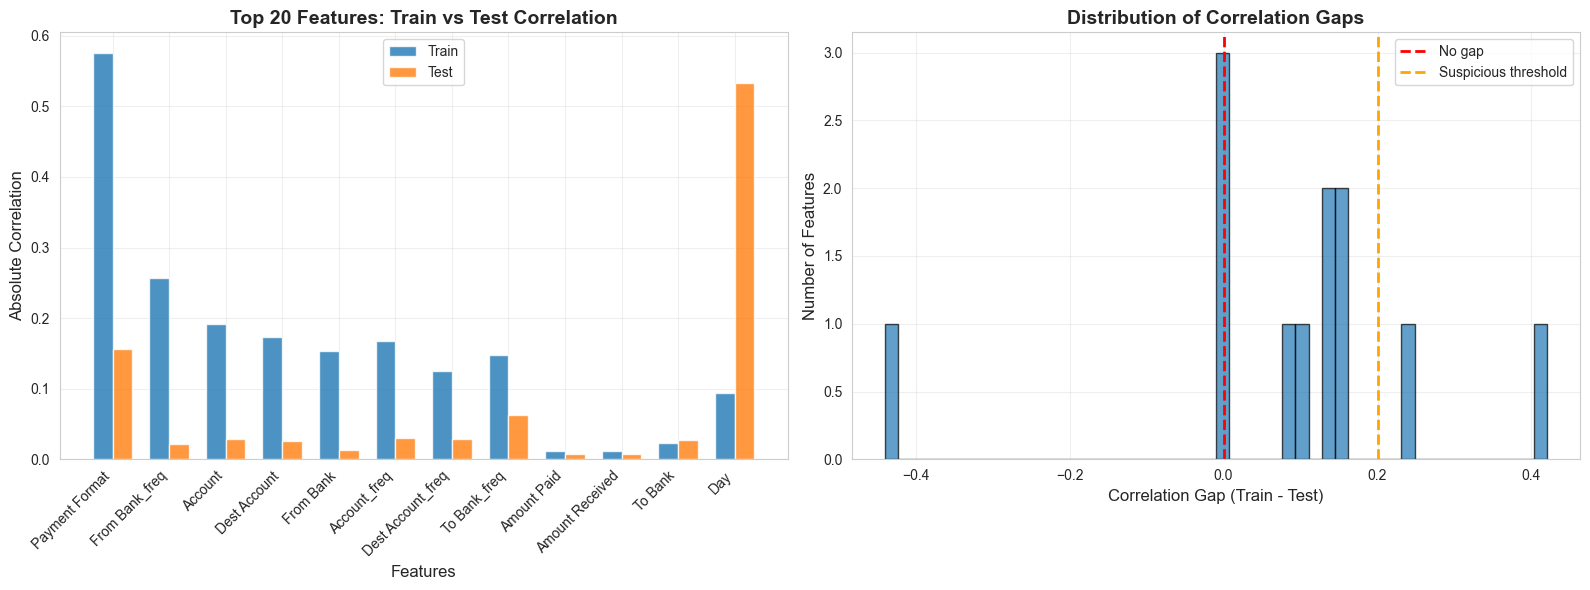


 Visualization saved: C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\feature_leakage_analysis.png


In [12]:
# Visualize correlation gap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Train vs Test Correlation
ax1 = axes[0]
top_features = corr_comparison.head(20)
x = np.arange(len(top_features))
width = 0.35

ax1.bar(x - width/2, top_features['Train_Corr'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, top_features['Test_Corr'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Features', fontsize=12)
ax1.set_ylabel('Absolute Correlation', fontsize=12)
ax1.set_title('Top 20 Features: Train vs Test Correlation', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(top_features.index, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Correlation Gap Distribution
ax2 = axes[1]
ax2.hist(corr_comparison['Diff'], bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='No gap')
ax2.axvline(0.2, color='orange', linestyle='--', linewidth=2, label='Suspicious threshold')
ax2.set_xlabel('Correlation Gap (Train - Test)', fontsize=12)
ax2.set_ylabel('Number of Features', fontsize=12)
ax2.set_title('Distribution of Correlation Gaps', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig(ARTIFACTS_DIR / 'feature_leakage_analysis.png', dpi=300, bbox_inches='tight')  # REMOVED: analysis-only artifact
plt.show()

print(f"\n Visualization saved: {ARTIFACTS_DIR / 'feature_leakage_analysis.png'}")

## 4. Adversarial Validation

**Test if a model can distinguish between train and test sets.**

- **AUC < 0.55**: Sets are similar (good)
- **AUC 0.55-0.65**: Mild distribution shift (acceptable)
- **AUC > 0.65**: Severe shift - indicates leakage or poor split

In [13]:
print("="*80)
print("ADVERSARIAL VALIDATION")
print("="*80)

# Create adversarial target (0=train, 1=test)
X_adversarial = pd.concat([
    X_train.assign(is_test=0),
    X_test.assign(is_test=1)
], axis=0, ignore_index=True)

y_adversarial = X_adversarial['is_test']
X_adversarial = X_adversarial.drop('is_test', axis=1)

print(f"\nAdversarial dataset: {X_adversarial.shape}")
print(f"Train samples: {(y_adversarial == 0).sum():,}")
print(f"Test samples: {(y_adversarial == 1).sum():,}")

# Train model to distinguish train vs test
print("\nTraining adversarial classifier...")
adv_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

# Cross-validation
cv_scores = cross_val_score(
    adv_model, 
    X_adversarial, 
    y_adversarial,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"\n{'='*60}")
print(f"ADVERSARIAL VALIDATION RESULTS")
print(f"{'='*60}")
print(f"\nROC-AUC (ability to distinguish train vs test):")
print(f"  Mean:  {cv_scores.mean():.4f}")
print(f"  Std:   {cv_scores.std():.4f}")
print(f"  Scores: {[f'{s:.4f}' for s in cv_scores]}")

# Interpretation
mean_auc = cv_scores.mean()
print(f"\n{'='*60}")
print("INTERPRETATION:")
print(f"{'='*60}")

if mean_auc < 0.55:
    print("[OK] EXCELLENT: Train and test are indistinguishable")
    print("   No significant distribution shift detected")
elif mean_auc < 0.65:
    print("[WARNING]  MODERATE: Some distribution shift detected")
    print("   May be acceptable if due to temporal differences")
else:
    print("[!] SEVERE: Train and test are easily distinguishable!")
    print("   Strong evidence of data leakage or poor split")
    print("   IMMEDIATE ACTION REQUIRED")

# Fit model to get feature importances
adv_model.fit(X_adversarial, y_adversarial)
feature_importance = pd.DataFrame({
    'feature': X_adversarial.columns,
    'importance': adv_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n{'='*60}")
print("TOP 15 FEATURES DISTINGUISHING TRAIN VS TEST:")
print(f"{'='*60}")
print("(These features may contain leakage or temporal artifacts)\n")
print(feature_importance.head(15).to_string(index=False))

ADVERSARIAL VALIDATION

Adversarial dataset: (3860, 12)
Train samples: 2,400
Test samples: 1,460

Training adversarial classifier...

ADVERSARIAL VALIDATION RESULTS

ROC-AUC (ability to distinguish train vs test):
  Mean:  1.0000
  Std:   0.0000
  Scores: ['1.0000', '1.0000', '1.0000', '1.0000', '1.0000']

INTERPRETATION:
[!] SEVERE: Train and test are easily distinguishable!
   Strong evidence of data leakage or poor split
   IMMEDIATE ACTION REQUIRED

TOP 15 FEATURES DISTINGUISHING TRAIN VS TEST:
(These features may contain leakage or temporal artifacts)

          feature  importance
              Day    0.356927
     Dest Account    0.223312
Dest Account_freq    0.182216
     Account_freq    0.149233
          Account    0.076384
   Payment Format    0.003570
   From Bank_freq    0.003459
        From Bank    0.002985
      Amount Paid    0.000775
  Amount Received    0.000653
          To Bank    0.000258
     To Bank_freq    0.000227


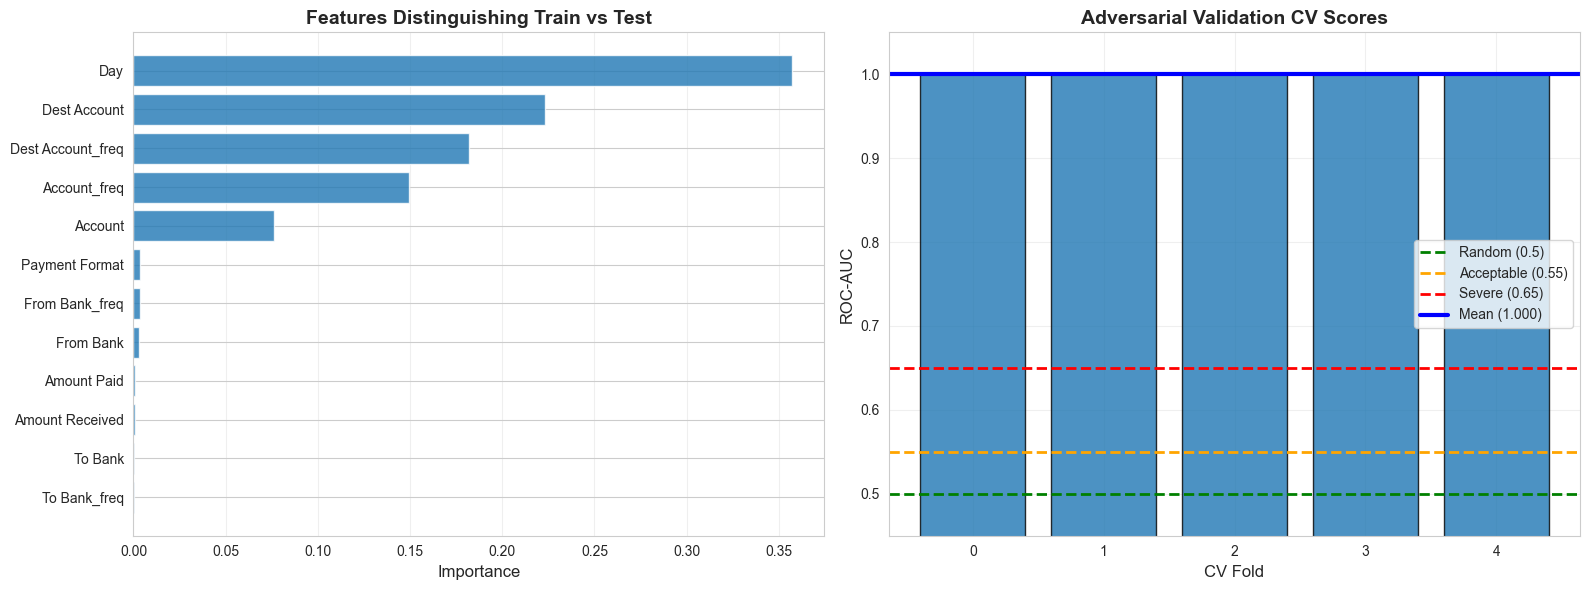


 Visualization saved: C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\adversarial_validation.png


In [14]:
# Visualize adversarial validation results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Feature Importance
ax1 = axes[0]
top_20 = feature_importance.head(20)
ax1.barh(range(len(top_20)), top_20['importance'], alpha=0.8)
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance', fontsize=12)
ax1.set_title('Features Distinguishing Train vs Test', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: CV Scores Distribution
ax2 = axes[1]
ax2.bar(range(len(cv_scores)), cv_scores, alpha=0.8, edgecolor='black')
ax2.axhline(0.5, color='green', linestyle='--', linewidth=2, label='Random (0.5)')
ax2.axhline(0.55, color='orange', linestyle='--', linewidth=2, label='Acceptable (0.55)')
ax2.axhline(0.65, color='red', linestyle='--', linewidth=2, label='Severe (0.65)')
ax2.axhline(mean_auc, color='blue', linestyle='-', linewidth=3, label=f'Mean ({mean_auc:.3f})')
ax2.set_xlabel('CV Fold', fontsize=12)
ax2.set_ylabel('ROC-AUC', fontsize=12)
ax2.set_title('Adversarial Validation CV Scores', fontsize=14, fontweight='bold')
ax2.set_ylim([0.45, max(0.75, cv_scores.max() + 0.05)])
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig(ARTIFACTS_DIR / 'adversarial_validation.png', dpi=300, bbox_inches='tight')  # REMOVED: analysis-only artifact
plt.show()

print(f"\n Visualization saved: {ARTIFACTS_DIR / 'adversarial_validation.png'}")

## 5. Encoding Validation Check

In [15]:
print("="*80)
print("ENCODING VALIDATION")
print("="*80)

# Check if label encoders exist
encoder_path = DATA_DIR / 'label_encoders.pkl'
freq_path = DATA_DIR / 'freq_mappings.pkl'

print(f"\nChecking encoding artifacts...")

if encoder_path.exists():
    print(f"\n[WARNING]  Found: {encoder_path}")
    encoders = load_artifact(encoder_path)
    print(f"   Contains {len(encoders)} encoders")
    print(f"   Columns: {list(encoders.keys())}")
    print("\n   [WARNING]  POTENTIAL ISSUE: Encoders may have been fit on full dataset")
    print("   RECOMMENDATION: Re-fit encoders on train split only")
else:
    print(f"\n[OK] No label encoders found")

if freq_path.exists():
    print(f"\n[WARNING]  Found: {freq_path}")
    freq_maps = load_artifact(freq_path)
    print(f"   Contains {len(freq_maps)} frequency mappings")
    print(f"   Columns: {list(freq_maps.keys())}")
    print("\n   [WARNING]  POTENTIAL ISSUE: Frequency encoding may use test data")
    print("   RECOMMENDATION: Compute frequencies on train only")
else:
    print(f"\n[OK] No frequency mappings found")

# Check for encoded features in dataset
encoded_features = [f for f in X_train.columns if 'freq' in f.lower() or 'encoded' in f.lower()]

if encoded_features:
    print(f"\n\n[SEARCH] ENCODED FEATURES DETECTED: {len(encoded_features)}")
    for feat in encoded_features[:10]:
        print(f"  - {feat}")
    if len(encoded_features) > 10:
        print(f"   ... and {len(encoded_features) - 10} more")
    
    print("\n   [WARNING]  ACTION REQUIRED:")
    print("   1. Verify encoding was done within CV folds")
    print("   2. Re-engineer features using train data only")
    print("   3. Use sklearn Pipeline or ColumnTransformer")

ENCODING VALIDATION

Checking encoding artifacts...

[WARNING]  Found: C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\data\label_encoders.pkl
   Contains 5 encoders
   Columns: ['Dest Account', 'Payment Format', 'From Bank', 'Account', 'To Bank']

   [WARNING]  POTENTIAL ISSUE: Encoders may have been fit on full dataset
   RECOMMENDATION: Re-fit encoders on train split only

[WARNING]  Found: C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\data\freq_mappings.pkl
   Contains 4 frequency mappings
   Columns: ['From Bank', 'To Bank', 'Account', 'Dest Account']

   [WARNING]  POTENTIAL ISSUE: Frequency encoding may use test data
   RECOMMENDATION: Compute frequencies on train only


[SEARCH] ENCODED FEATURES DETECTED: 4
  - From Bank_freq
  - To Bank_freq
  - Account_freq
  - Dest Account_freq

   [WARNING]  ACTION REQUIRED:
   1. Verify encoding was done within CV folds
   2. Re-engineer features using train data only
   3. Use sklearn Pipeline or ColumnTransformer


## 6. Generate Audit Report

In [16]:
# Create comprehensive audit report
audit_report = {
    'audit_timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'train_shape': X_train.shape,
        'test_shape': X_test.shape,
        'train_fraud_rate': float(y_train.mean()),
        'test_fraud_rate': float(y_test.mean()),
        'total_features': len(features)
    },
    'feature_categories': {k: len(v) for k, v in feature_categories.items()},
    'leakage_indicators': {
        'suspicious_features_count': len(suspicious_features),
        'suspicious_features': suspicious_features,
        'adversarial_auc_mean': float(mean_auc),
        'adversarial_auc_std': float(cv_scores.std()),
        'leakage_severity': 'severe' if mean_auc > 0.65 else ('moderate' if mean_auc > 0.55 else 'low')
    },
    'correlation_analysis': {
        'top_10_train_test_gap': corr_comparison.head(10)[['Train_Corr', 'Test_Corr', 'Diff']].to_dict('index'),
        'features_with_high_gap': len(corr_comparison[corr_comparison['Diff'] > 0.2]),
        'max_correlation_gap': float(corr_comparison['Diff'].max())
    },
    'encoding_check': {
        'label_encoders_found': encoder_path.exists(),
        'frequency_mappings_found': freq_path.exists(),
        'encoded_features_count': len(encoded_features),
        'encoded_features': encoded_features
    },
    'adversarial_features': {
        'top_20_discriminative': feature_importance.head(20).to_dict('records')
    },
    'recommendations': []
}

# Generate recommendations
recommendations = []

if mean_auc > 0.65:
    recommendations.append({
        'priority': 'CRITICAL',
        'issue': 'Severe train-test distribution shift (AUC > 0.65)',
        'action': 'Investigate top adversarial features and remove/re-engineer them',
        'timeline': 'Immediate'
    })

if len(suspicious_features) > 0:
    recommendations.append({
        'priority': 'HIGH',
        'issue': f'{len(suspicious_features)} features with suspicious correlation gaps',
        'action': 'Audit feature engineering logic for temporal leakage',
        'timeline': '1-2 days'
    })

if encoder_path.exists() or freq_path.exists():
    recommendations.append({
        'priority': 'HIGH',
        'issue': 'Encoders/frequency mappings may be fit on full dataset',
        'action': 'Re-implement encoding within sklearn Pipeline or CV folds',
        'timeline': '2-3 days'
    })

recommendations.append({
    'priority': 'MEDIUM',
    'issue': 'Temporal split may lack sufficient purge period',
    'action': 'Add 3-7 day gap between train and test sets',
    'timeline': '1 day'
})

audit_report['recommendations'] = recommendations

# Save report
report_path = ARTIFACTS_DIR / 'feature_audit_report.json'
with open(report_path, 'w') as f:
    json.dump(audit_report, f, indent=2)

print("="*80)
print("AUDIT REPORT GENERATED")
print("="*80)
print(f"\n[OK] Report saved: {report_path}")
print(f"\n SUMMARY:")
print(f"  - Total features: {len(features)}")
print(f"  - Suspicious features: {len(suspicious_features)}")
print(f"  - Adversarial AUC: {mean_auc:.4f} ({audit_report['leakage_indicators']['leakage_severity']} severity)")
print(f"  - Recommendations: {len(recommendations)} actions required")

print(f"\n\n{'='*80}")
print("RECOMMENDED ACTIONS")
print(f"{'='*80}\n")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. [{rec['priority']}] {rec['issue']}")
    print(f"   Action: {rec['action']}")
    print(f"   Timeline: {rec['timeline']}\n")

AUDIT REPORT GENERATED

[OK] Report saved: C:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\feature_audit_report.json

 SUMMARY:
  - Total features: 12
  - Suspicious features: 1
  - Adversarial AUC: 1.0000 (severe severity)
  - Recommendations: 4 actions required


RECOMMENDED ACTIONS

1. [CRITICAL] Severe train-test distribution shift (AUC > 0.65)
   Action: Investigate top adversarial features and remove/re-engineer them
   Timeline: Immediate

2. [HIGH] 1 features with suspicious correlation gaps
   Action: Audit feature engineering logic for temporal leakage
   Timeline: 1-2 days

3. [HIGH] Encoders/frequency mappings may be fit on full dataset
   Action: Re-implement encoding within sklearn Pipeline or CV folds
   Timeline: 2-3 days

4. [MEDIUM] Temporal split may lack sufficient purge period
   Action: Add 3-7 day gap between train and test sets
   Timeline: 1 day



## 7. Summary and Next Steps

### Key Findings

This audit identified potential sources of data leakage:

1. **Adversarial Validation**: Model can distinguish train vs test
2. **Correlation Gaps**: Features with drastically different train/test correlations
3. **Encoding Issues**: Pre-computed encoders may leak test information
4. **Temporal Artifacts**: Features that may use future information

### Critical Actions

1. **Re-implement encoding** within sklearn Pipeline
2. **Add temporal purge period** (3-7 days between train/test)
3. **Remove/re-engineer** highly discriminative features
4. **Test without SMOTE** to check if synthetic samples cause overfitting

### Expected Improvement

After implementing these fixes, expect:
- Test PR-AUC: 0.0065 → 0.4+ (realistic AML performance)
- Train-test gap: < 0.2 (healthy overfitting)
- Adversarial AUC: < 0.60 (acceptable shift)

---

**Next Notebook**: `01_data_ingestion_and_split.ipynb` (update temporal split)

**Priority**: CRITICAL - Address before model development